# Assignment 1


In [146]:
import pandas as pd
from datetime import datetime
from scipy.optimize import fsolve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Choosing 10 Bonds

In [147]:
price_data = pd.read_csv("data.csv")
price_data.head()

,ISIN,issue date,coupon,maturity date,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan,20-Jan
0,CA135087M847,10/15/2021,1.25%,3/1/2027,96.62,96.59,96.58,96.63,96.39,96.28,96.19,96.36,96.60,96.64,96.69
1,CA135087VW17,5/1/1996,8.00%,6/1/2027,111.80,111.85,111.76,111.76,111.48,111.33,111.13,111.41,111.51,111.52,111.54
2,CA135087R226,11/1/2023,4.50%,2/1/2026,101.58,101.58,101.56,101.58,101.46,101.39,101.35,101.42,101.52,101.54,101.57
3,CA135087N837,5/13/2022,2.75%,9/1/2027,99.63,99.56,99.54,99.58,99.27,99.13,99.02,99.20,99.50,99.53,99.61
4,CA135087S398,8/2/2024,3.25%,11/1/2026,100.47,100.41,100.42,100.46,100.23,100.13,100.06,100.20,100.41,100.42,100.46


Choose 10 bonds that pay coupons at equally spaced intervals such that linear interpolation is not required.


In [148]:
price_data["maturity date"] = pd.to_datetime(price_data["maturity date"], format="%m/%d/%Y")
coupon_maturity_date_df = price_data.loc[:, ["maturity date", "coupon"]]
coupon_maturity_date_df.sort_values(by=["maturity date", "coupon"], inplace=True)
coupon_maturity_date_df

,maturity date,coupon
16,2025-02-01,3.75%
5,2025-03-01,1.25%
15,2025-04-01,1.50%
9,2025-05-01,3.75%
8,2025-06-01,2.25%
6,2025-06-01,9.00%
22,2025-08-01,3.50%
12,2025-09-01,0.50%
18,2025-10-01,3.00%
14,2025-11-01,4.50%


Notice that each of our selected bonds (March and September maturities) are dated one the 1st of the month so we do not have to worry about differences in days, they are equally spaced by 6 months exactly.


## 4(a) Constructing YTM Curve


In [149]:
price_data["maturity date"] = price_data["maturity date"].dt.strftime("%Y-%m")
price_data.set_index("maturity date", inplace=True)

price_data['coupon'] = price_data['coupon'].str.replace('%', '').astype(float) / 100

selected_bond_maturities = [
    "2025-03",
    "2025-09",
    "2026-03",
    "2026-09",
    "2027-03",
    "2027-09",
    "2028-03",
    "2028-09",
    "2029-03",
    "2029-09",
    "2030-03",
]
selected_bonds_df = price_data[price_data.index.isin(selected_bond_maturities)]
selected_bonds_df.sort_index(inplace=True)
selected_bonds_df.head()

/var/folders/3m/2lzp5b051qd01070jvyf9zw80000gn/T/ipykernel_66409/1088418678.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds_df.sort_index(inplace=True)


,ISIN,issue date,coupon,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan,20-Jan
maturity date,,,,,,,,,,,,,,
2025-03,CA135087K528,10/11/2019,0.0125,99.73,99.73,99.74,99.73,99.74,99.73,99.73,99.77,99.78,99.80,99.80
2025-09,CA135087K940,4/3/2020,0.0050,98.40,98.41,98.40,98.42,98.37,98.36,98.36,98.40,98.47,98.50,98.53
2026-03,CA135087L518,10/9/2020,0.0025,96.99,96.98,96.97,97.00,96.90,96.91,96.80,96.90,97.01,97.06,97.10
2026-09,CA135087L930,4/16/2021,0.0100,97.01,96.99,97.00,97.03,96.86,96.77,96.71,96.85,97.03,97.07,97.11
2027-03,CA135087M847,10/15/2021,0.0125,96.62,96.59,96.58,96.63,96.39,96.28,96.19,96.36,96.60,96.64,96.69


In [150]:
dates = [date for date in price_data.columns if "Jan" in date]

face_value = 100

# Update the clean prices to dirty prices
for data_date in dates:
    data_date_as_dt = datetime.strptime(data_date, "%d-%b")
    data_date_as_dt = data_date_as_dt.replace(year=2025)
    for row in selected_bonds_df.iterrows():
        bond_maturity_date_as_dt = row[0]
        bond_maturity_date_as_dt = datetime.strptime(bond_maturity_date_as_dt, "%Y-%m")

        # Find the most recent coupon date
        while bond_maturity_date_as_dt > data_date_as_dt:
            bond_maturity_date_as_dt = bond_maturity_date_as_dt - pd.DateOffset(months=6)

        # Calculate the number of days since the last coupon date
        days_since_last_coupon = (data_date_as_dt - bond_maturity_date_as_dt).days

        # Calculate the accrued interest
        accrued_interest = (days_since_last_coupon / 180) * (row[1]["coupon"] / 2) * face_value

        # Update the clean price to dirty price
        clean_price = selected_bonds_df.loc[row[0], data_date]
        dirty_price = clean_price + accrued_interest
        selected_bonds_df.loc[row[0], data_date] = dirty_price

selected_bonds_df.head()

,ISIN,issue date,coupon,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan,20-Jan
maturity date,,,,,,,,,,,,,,
2025-03,CA135087K528,10/11/2019,0.0125,100.170972,100.174444,100.187917,100.181389,100.194861,100.195278,100.19875,100.242222,100.255694,100.279167,100.289583
2025-09,CA135087K940,4/3/2020,0.0050,98.576389,98.587778,98.579167,98.600556,98.551944,98.546111,98.54750,98.588889,98.660278,98.691667,98.725833
2026-03,CA135087L518,10/9/2020,0.0025,97.078194,97.068889,97.059583,97.090278,96.990972,97.003056,96.89375,96.994444,97.105139,97.155833,97.197917
2026-09,CA135087L930,4/16/2021,0.0100,97.362778,97.345556,97.358333,97.391111,97.223889,97.142222,97.08500,97.227778,97.410556,97.453333,97.501667
2027-03,CA135087M847,10/15/2021,0.0125,97.060972,97.034444,97.027917,97.081389,96.844861,96.745278,96.65875,96.832222,97.075694,97.119167,97.179583


In [151]:
def bond_price_ytm(ytm, face_value, semi_annual_coupon_rate, PV, coupon_times):
    """Computes the difference between the bond price and the present value of the bond given a yield-to-maturity for a bond paying semi-annual coupons with continuous compounding.

    Args:
        ytm (float): The yield-to-maturity.
        face_value (float): The face value of the bond.
        semi_annual_coupon_rate (float): The semi-annual coupon rate.
        PV (float): The present value of the bond.
        coupon_times (list): A list of fractions of years at which the bond pays a coupon.

    Returns:
        float: The difference between the bond price and the present value of the bond given a yield-to
    """
    bond_price = 0

    # Discount coupon payments
    for coupon_time in coupon_times:
        bond_price += (semi_annual_coupon_rate * face_value) * np.exp(-ytm * coupon_time)

    # Discount face value
    bond_price += face_value * np.exp(-ytm * coupon_times[-1])

    return bond_price - PV


ytm_df = pd.DataFrame(index=selected_bonds_df.index, columns=dates)

for data_date in dates:
    data_date_as_dt = datetime.strptime(data_date, "%d-%b")
    data_date_as_dt = data_date_as_dt.replace(year=2025)
    for row in selected_bonds_df.iterrows():
        bond_maturity_date_as_dt = row[0]
        bond_maturity_date_as_dt = datetime.strptime(bond_maturity_date_as_dt, "%Y-%m")

        ytm_guess = 0.05
        face_value = 100
        semi_annual_coupon_rate = row[1]["coupon"] / 2
        PV = row[1][data_date]

        coupon_times = []
        cur_bond_coupon_date = bond_maturity_date_as_dt
        while cur_bond_coupon_date > data_date_as_dt:
            coupon_times.append((cur_bond_coupon_date - data_date_as_dt).days / 365)
            cur_bond_coupon_date -= pd.DateOffset(months=6)
        
        # Reverse the list so that the first element is the time to the next coupon payment
        coupon_times = coupon_times[::-1]

        ytm_df.loc[row[0], data_date] = fsolve(
            bond_price_ytm,
            ytm_guess,
            args=(face_value, semi_annual_coupon_rate, PV, coupon_times),
        )[0]

ytm_df

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan,20-Jan
maturity date,,,,,,,,,,,
2025-03,0.030567,0.030905,0.030556,0.031621,0.031272,0.033236,0.033683,0.030914,0.030501,0.029224,0.030467
2025-09,0.029696,0.029643,0.029905,0.029694,0.030592,0.031084,0.031197,0.030663,0.029637,0.029255,0.029082
2026-03,0.02914,0.029294,0.029448,0.029241,0.030213,0.030323,0.0314,0.030551,0.029606,0.029211,0.029037
2026-09,0.028422,0.028578,0.028546,0.028387,0.029492,0.030161,0.030577,0.029718,0.028601,0.028377,0.028212
2027-03,0.028626,0.028792,0.028862,0.028638,0.029834,0.030441,0.030908,0.030091,0.028929,0.028752,0.028567
2027-09,0.028694,0.028968,0.029047,0.028892,0.030109,0.030668,0.031105,0.030397,0.029216,0.0291,0.028788
2028-03,0.02866,0.028655,0.029042,0.028971,0.029621,0.030464,0.031253,0.030522,0.029396,0.029161,0.028948
2028-09,0.029019,0.028902,0.029327,0.029467,0.029894,0.03075,0.031613,0.030949,0.029509,0.02922,0.028954
2029-03,0.029252,0.029394,0.029661,0.02973,0.030572,0.031156,0.031906,0.031271,0.02986,0.029604,0.029284


(2.8, 4.0)

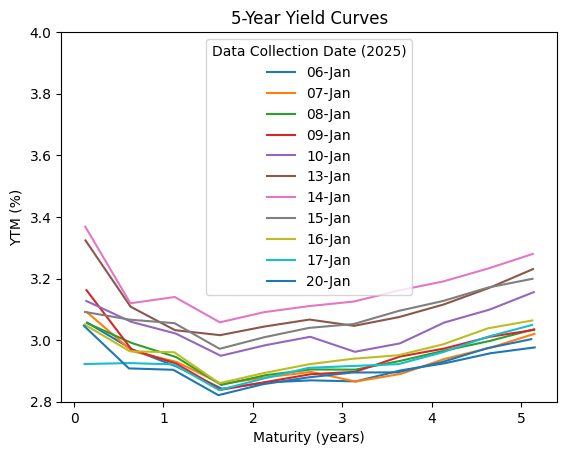

In [152]:
plt.figure()

for data_date in dates:
    data_date_as_dt = datetime.strptime(data_date, "%d-%b")
    data_date_as_dt = data_date_as_dt.replace(year=2025)
     
    maturities_axis = []
    for maturity in ytm_df.index:
        bond_maturity_date_as_dt = datetime.strptime(maturity, "%Y-%m")
        
        maturities_axis.append((bond_maturity_date_as_dt - data_date_as_dt).days / 365)
    
    plt.plot(maturities_axis, ytm_df.loc[:, data_date].values * 100, label=data_date)

plt.legend(title="Data Collection Date (2025)")
plt.xlabel("Maturity (years)")
plt.ylabel("YTM (%)")
plt.title("5-Year Yield Curves")

plt.ylim(2.8, 4)

## 4(b) Constructing Spot Rate Curve


In [153]:
spot_rates_df = pd.DataFrame(columns=dates, index=selected_bonds_df.index)
spot_rates_df.head()

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan,20-Jan
maturity date,,,,,,,,,,,
2025-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
for data_date in dates:
    data_date_as_dt = datetime.strptime(data_date, "%d-%b")
    data_date_as_dt = data_date_as_dt.replace(year=2025)

    for row_index, row in enumerate(selected_bonds_df.iterrows()):
        bond_maturity_date_as_dt = row[0]
        bond_maturity_date_as_dt = datetime.strptime(bond_maturity_date_as_dt, "%Y-%m")

        PV = row[1][data_date]

        coupon_dates = []
        cur_coupon_date = bond_maturity_date_as_dt
        while cur_coupon_date > data_date_as_dt:
            coupon_dates.append(
                [
                    (cur_coupon_date - data_date_as_dt).days / 365,
                    f"{cur_coupon_date.year}-{cur_coupon_date.month:02}",
                ]
            )
            cur_coupon_date -= pd.DateOffset(months=6)

        # Reverse the list so that the first element is the time to the next coupon payment
        coupon_dates = coupon_dates[::-1]

        face_value = 100

        semi_annual_coupon_rate = selected_bonds_df.loc[row[0], "coupon"] / 2
        semi_annual_coupon_value = face_value * semi_annual_coupon_rate

        if len(coupon_dates) == 1:
            time_to_maturity = coupon_dates[0][0]
            r = -np.log(PV / (face_value + semi_annual_coupon_value)) / time_to_maturity
            spot_rates_df.loc[row[0], data_date] = r
        else:
            for coupon_time, coupon_date in coupon_dates[:-1]:
                PV -= semi_annual_coupon_value * np.exp(
                    -spot_rates_df.loc[coupon_date, data_date] * coupon_time
                )
            time_to_maturity = coupon_dates[-1][0]
            r = -np.log(PV / (face_value + semi_annual_coupon_value)) / time_to_maturity
            spot_rates_df.loc[row[0], data_date] = r

spot_rates_df

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan,20-Jan
maturity date,,,,,,,,,,,
2025-03,0.030567,0.030905,0.030556,0.031621,0.031272,0.033236,0.033683,0.030914,0.030501,0.029224,0.030467
2025-09,0.029696,0.029643,0.029904,0.029693,0.030592,0.031083,0.031196,0.030663,0.029636,0.029255,0.029082
2026-03,0.02914,0.029293,0.029448,0.029241,0.030213,0.030322,0.0314,0.03055,0.029606,0.029211,0.029036
2026-09,0.028416,0.028572,0.028539,0.02838,0.029486,0.030157,0.030572,0.029712,0.028595,0.028372,0.028207
2027-03,0.028622,0.028789,0.028858,0.028634,0.029832,0.030441,0.030907,0.03009,0.028926,0.028751,0.028565
2027-09,0.028689,0.028967,0.029047,0.028893,0.030114,0.030673,0.031108,0.030404,0.02922,0.029109,0.028792
2028-03,0.028654,0.02864,0.029041,0.028975,0.029604,0.03046,0.031263,0.030536,0.029409,0.029173,0.02896
2028-09,0.029032,0.028903,0.029342,0.029497,0.029894,0.030762,0.03164,0.030982,0.029525,0.029233,0.028964
2029-03,0.029284,0.029432,0.029702,0.029781,0.030623,0.0312,0.031957,0.031331,0.029904,0.029647,0.029319


(2.8, 4.0)

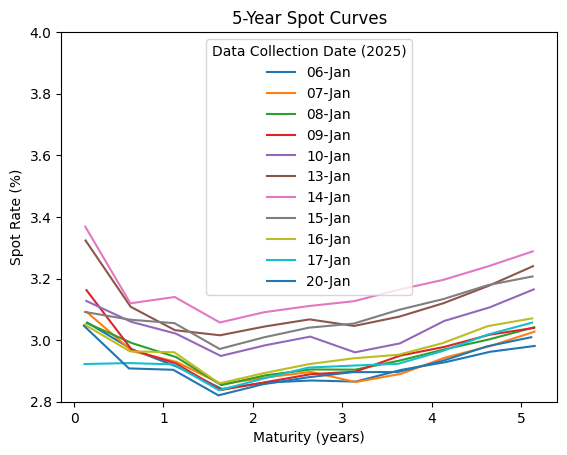

In [155]:
plt.figure()

for data_date in dates:
    data_date_as_dt = datetime.strptime(data_date, "%d-%b")
    data_date_as_dt = data_date_as_dt.replace(year=2025)

    maturities_axis = []
    for maturity in spot_rates_df.index:
        bond_maturity_date_as_dt = datetime.strptime(maturity, "%Y-%m")

        maturities_axis.append((bond_maturity_date_as_dt - data_date_as_dt).days / 365)

    plt.plot(
        maturities_axis, spot_rates_df.loc[:, data_date].values * 100, label=data_date
    )

plt.legend(title="Data Collection Date (2025)")
plt.xlabel("Maturity (years)")
plt.ylabel("Spot Rate (%)")
plt.title("5-Year Spot Curves")

plt.ylim(2.8, 4)

## 4(c) Constructing Forward Curve

In [156]:
# Consider bonds starting from 2026-03
# Remove first row - 2025-03
forward_rates_maturities = selected_bonds_df.index
forward_rates_maturities = [maturity for maturity in forward_rates_maturities if '-03' in maturity]
forward_rates_maturities = forward_rates_maturities[1:]

forward_rates_df = pd.DataFrame(columns=dates, index=forward_rates_maturities)

forward_rates_df.head()

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan,20-Jan
2026-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
for data_date in dates:
    data_date_as_dt = datetime.strptime(data_date, "%d-%b")
    data_date_as_dt = data_date_as_dt.replace(year=2025)

    yr1_maturity_date = forward_rates_df.index[0]
    yr1_maturity_date = datetime.strptime(yr1_maturity_date, "%Y-%m")

    yr1_spot_rate = spot_rates_df.loc[forward_rates_df.index[0], data_date]

    yr1_time = (yr1_maturity_date - data_date_as_dt).days / 365

    for row_index, row in enumerate(selected_bonds_df.iterrows()):
        bond_maturity_date_as_dt = row[0]

        if bond_maturity_date_as_dt not in forward_rates_df.index:
            continue

        bond_maturity_date_as_dt = datetime.strptime(row[0], "%Y-%m")

        bond_spot_rate = spot_rates_df.loc[row[0], data_date]
        bond_time = (bond_maturity_date_as_dt - data_date_as_dt).days / 365

        forward_rates_df.loc[row[0], data_date] = (
            bond_spot_rate * (bond_time + yr1_time) - yr1_spot_rate
        ) / yr1_time

# Remove the 1yr-0yr forward rate
forward_rates_df = forward_rates_df[1:]
forward_rates_df

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan,20-Jan
2027-03,0.056794,0.057138,0.057201,0.056735,0.059329,0.060986,0.061375,0.059771,0.057246,0.057092,0.056706
2028-03,0.081914,0.081785,0.083216,0.08321,0.084781,0.088103,0.090244,0.088317,0.08496,0.084484,0.084022
2029-03,0.109785,0.110457,0.111696,0.112368,0.115549,0.118535,0.121246,0.119218,0.113521,0.1128,0.111812
2030-03,0.138185,0.140787,0.14163,0.141891,0.148131,0.152834,0.154761,0.151207,0.144681,0.144461,0.14258


Text(0.5, 1.0, '1-Year Forward Curves')

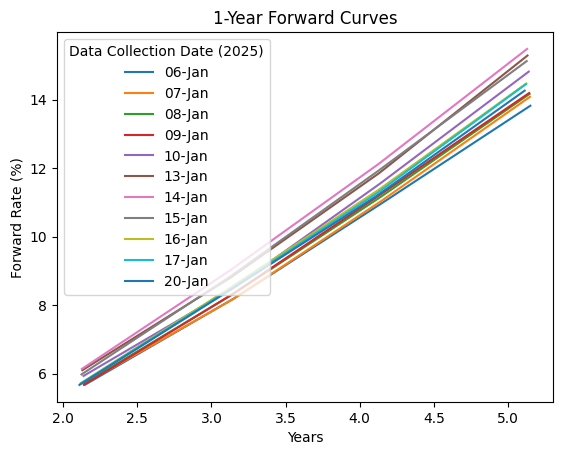

In [158]:
plt.figure()

for data_date in forward_rates_df.columns:
    data_date_as_dt = datetime.strptime(data_date, "%d-%b")
    data_date_as_dt = data_date_as_dt.replace(year=2025)
     
    maturities_axis = []
    for maturity in forward_rates_df.index:
        bond_maturity_date_as_dt = datetime.strptime(maturity, "%Y-%m")
        
        maturities_axis.append((bond_maturity_date_as_dt - data_date_as_dt).days / 365)
    
    plt.plot(maturities_axis, forward_rates_df.loc[:, data_date].values * 100, label=data_date)

plt.legend(title="Data Collection Date (2025)")
plt.xlabel("Years")
plt.ylabel("Forward Rate (%)")
plt.title("1-Year Forward Curves")

## 5 Covariance Matrices

### YTM

In [159]:
# We will calculate the covariance matrix for 5 maturities so only consider bonds with March maturities to cover 5 years
ytm_log_return_df_maturities = [maturity for maturity in ytm_df.index if "-03" in maturity]

ytm_log_returns_df = pd.DataFrame(index = ytm_log_return_df_maturities, columns = ytm_df.columns[:-1])
ytm_log_returns_df.head()

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan
2025-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
for i in range(len(ytm_log_returns_df.columns)):
    data_date_1 = ytm_df.columns[i]
    data_date_1_as_date = datetime.strptime(data_date, "%d-%b")
    data_date_1_as_date = data_date_as_dt.replace(year=2025)

    data_date_2 = ytm_df.columns[i+1]
    data_date_2_as_date = datetime.strptime(data_date, "%d-%b")
    data_date_2_as_date = data_date_as_dt.replace(year=2025)

    for row in ytm_log_returns_df.iterrows():
        ytm_log_returns_df.loc[row[0], data_date_1] = np.log(ytm_df.loc[row[0], data_date_2] / ytm_df.loc[row[0], data_date_1])
ytm_log_returns_df

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan
2025-03,0.010998,-0.011377,0.034275,-0.011105,0.060904,0.013376,-0.085809,-0.013425,-0.042795,0.041685
2026-03,0.00526,0.005258,-0.007054,0.032705,0.003628,0.034897,-0.027428,-0.031414,-0.013433,-0.005982
2027-03,0.005797,0.002402,-0.007786,0.040911,0.020158,0.015226,-0.026781,-0.039404,-0.006124,-0.006474
2028-03,-0.000186,0.013404,-0.002428,0.022197,0.028043,0.025571,-0.023656,-0.037582,-0.008042,-0.007328
2029-03,0.004855,0.009042,0.002301,0.027936,0.018936,0.023767,-0.020088,-0.04616,-0.008628,-0.010861
2030-03,0.014713,0.004896,-0.000649,0.039577,0.023449,0.015123,-0.024902,-0.043248,-0.004789,-0.015214


In [161]:
ytm_log_returns_cov_df = ytm_log_returns_df.T.cov()

new_index = [f"{years_to_maturity} Year(s) to Maturity" for years_to_maturity in range(len(ytm_log_returns_cov_df.index))]
ytm_log_returns_cov_df.index = new_index
ytm_log_returns_cov_df.columns = new_index
ytm_log_returns_cov_df

,0 Year(s) to Maturity,1 Year(s) to Maturity,2 Year(s) to Maturity,3 Year(s) to Maturity,4 Year(s) to Maturity,5 Year(s) to Maturity
0 Year(s) to Maturity,0.001839,0.000353,0.000396,0.000460,0.000383,0.000396
1 Year(s) to Maturity,0.000353,0.000484,0.000459,0.000421,0.000450,0.000468
2 Year(s) to Maturity,0.000396,0.000459,0.000529,0.000458,0.000489,0.000547
3 Year(s) to Maturity,0.000460,0.000421,0.000458,0.000467,0.000470,0.000483
4 Year(s) to Maturity,0.000383,0.000450,0.000489,0.000470,0.000505,0.000525
5 Year(s) to Maturity,0.000396,0.000468,0.000547,0.000483,0.000525,0.000591


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, '0 Year(s) to Maturity'),
  Text(1.5, 0, '1 Year(s) to Maturity'),
  Text(2.5, 0, '2 Year(s) to Maturity'),
  Text(3.5, 0, '3 Year(s) to Maturity'),
  Text(4.5, 0, '4 Year(s) to Maturity'),
  Text(5.5, 0, '5 Year(s) to Maturity')])

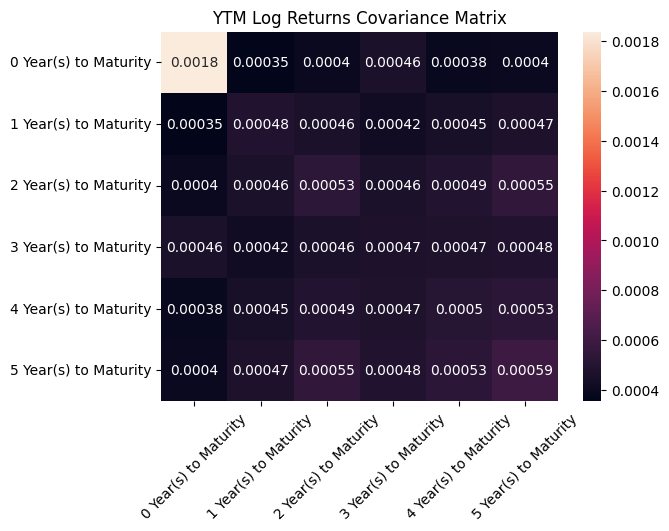

In [162]:
plt.figure()
sns.heatmap(ytm_log_returns_cov_df, annot=True)
plt.title("YTM Log Returns Covariance Matrix")
plt.xticks(rotation=45)

### Forward Rates

In [163]:
forward_rates_log_returns_df = pd.DataFrame(index = forward_rates_df.index, columns = forward_rates_df.columns[:-1])
forward_rates_log_returns_df.head()

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan
2027-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
for i in range(len(forward_rates_log_returns_df.columns)):
    data_date_1 = forward_rates_df.columns[i]
    data_date_1_as_date = datetime.strptime(data_date, "%d-%b")
    data_date_1_as_date = data_date_as_dt.replace(year=2025)

    data_date_2 = forward_rates_df.columns[i+1]
    data_date_2_as_date = datetime.strptime(data_date, "%d-%b")
    data_date_2_as_date = data_date_as_dt.replace(year=2025)

    for row in forward_rates_log_returns_df.iterrows():
        forward_rates_log_returns_df.loc[row[0], data_date_1] = np.log(forward_rates_df.loc[row[0], data_date_2] / forward_rates_df.loc[row[0], data_date_1])
forward_rates_log_returns_df

,06-Jan,07-Jan,08-Jan,09-Jan,10-Jan,13-Jan,14-Jan,15-Jan,16-Jan,17-Jan
2027-03,0.006041,0.001101,-0.008183,0.044709,0.027549,0.006357,-0.02648,-0.043164,-0.002699,-0.006784
2028-03,-0.001572,0.017345,-0.000068,0.018701,0.038432,0.024019,-0.021586,-0.038754,-0.005626,-0.005481
2029-03,0.006098,0.011155,0.006,0.027915,0.025517,0.022613,-0.016866,-0.048966,-0.006375,-0.008792
2030-03,0.018657,0.005964,0.001846,0.043038,0.031252,0.012528,-0.023228,-0.04412,-0.001522,-0.013103


In [165]:
forward_rates_log_returns_cov_df = forward_rates_log_returns_df.T.cov()

new_index = [f"1yr-{years}yr" for years in range(1, len(forward_rates_log_returns_cov_df.index) + 1)]
forward_rates_log_returns_cov_df.index = new_index
forward_rates_log_returns_cov_df.columns = new_index
forward_rates_log_returns_cov_df

,1yr-1yr,1yr-2yr,1yr-3yr,1yr-4yr
1yr-1yr,0.000613,0.000484,0.000526,0.000621
1yr-2yr,0.000484,0.000519,0.000503,0.000510
1yr-3yr,0.000526,0.000503,0.000545,0.000566
1yr-4yr,0.000621,0.000510,0.000566,0.000659


Text(0.5, 1.0, 'Forward Rates Log Returns Covariance Matrix')

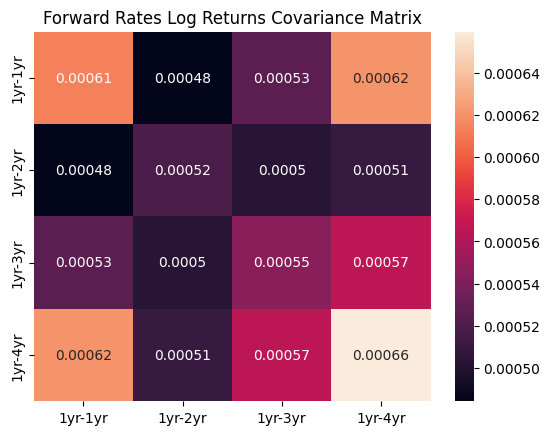

In [166]:
plt.figure()
sns.heatmap(forward_rates_log_returns_cov_df, annot=True)
plt.title("Forward Rates Log Returns Covariance Matrix")

## 6 Eigen

In [167]:
ytm_log_returns_eigenvalues, ytm_log_returns_eigenvectors = np.linalg.eig(ytm_log_returns_df.T.cov())
ytm_log_returns_eigenvectors = pd.DataFrame(ytm_log_returns_eigenvectors, columns=[f"eigenvalue {round(eigenvalue, 8)}" for eigenvalue in ytm_log_returns_eigenvalues])
ytm_log_returns_eigenvectors

,eigenvalue 0.00307136,eigenvalue 0.00120336,eigenvalue 4.23e-06,eigenvalue 1.455e-05,eigenvalue 4.89e-05,eigenvalue 7.22e-05
0,-0.585369,-0.808253,-0.015679,0.038391,-0.048472,0.000731
1,-0.336557,0.259369,0.153718,0.108373,-0.237234,-0.853114
2,-0.369105,0.275819,-0.443309,-0.583702,-0.457573,0.202685
3,-0.359342,0.189076,0.357733,-0.487985,0.684758,0.011296
4,-0.361293,0.272987,-0.598193,0.512710,0.411783,0.068364
5,-0.384934,0.305134,0.542028,0.380884,-0.305840,0.475724


In [168]:
first_component_explained_variance = ytm_log_returns_eigenvalues[0] / sum(ytm_log_returns_eigenvalues)
first_component_explained_variance

0.695728138535392

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'eigenvalue 0.00307136'),
  Text(1.5, 0, 'eigenvalue 0.00120336'),
  Text(2.5, 0, 'eigenvalue 4.23e-06'),
  Text(3.5, 0, 'eigenvalue 1.455e-05'),
  Text(4.5, 0, 'eigenvalue 4.89e-05'),
  Text(5.5, 0, 'eigenvalue 7.22e-05')])

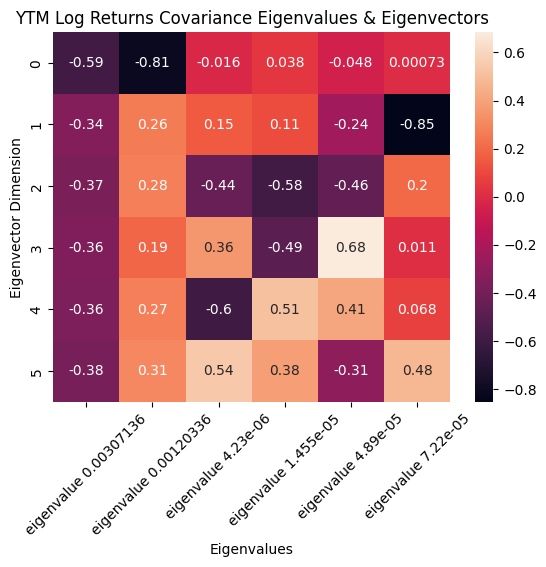

In [169]:
plt.figure()
sns.heatmap(ytm_log_returns_eigenvectors, annot=True)
plt.title("YTM Log Returns Covariance Eigenvalues & Eigenvectors")
plt.xlabel("Eigenvalues")
plt.ylabel("Eigenvector Dimension")
plt.xticks(rotation=45)

In [170]:
forward_rates_log_returns_eigenvalues, forward_rates_log_returns_eigenvectors = (
    np.linalg.eig(forward_rates_log_returns_df.T.cov())
)
forward_rates_log_returns_eigenvectors = pd.DataFrame(
    forward_rates_log_returns_eigenvectors,
    columns=[
        f"eigenvalue {round(eigenvalue, 8)}"
        for eigenvalue in forward_rates_log_returns_eigenvalues
    ],
)
forward_rates_log_returns_eigenvectors

,eigenvalue 0.00219699,eigenvalue 0.00010447,eigenvalue 2.683e-05,eigenvalue 8.72e-06
0,0.512899,0.505311,0.500499,0.480726
1,0.457895,-0.703292,0.482224,-0.251340
2,0.487256,-0.307056,-0.656811,0.486721
3,0.538376,0.394661,-0.292506,-0.684715


In [171]:
first_component_explained_variance = forward_rates_log_returns_eigenvalues[0] / sum(forward_rates_log_returns_eigenvalues)
first_component_explained_variance

0.9400858831976312

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'eigenvalue 0.00219699'),
  Text(1.5, 0, 'eigenvalue 0.00010447'),
  Text(2.5, 0, 'eigenvalue 2.683e-05'),
  Text(3.5, 0, 'eigenvalue 8.72e-06')])

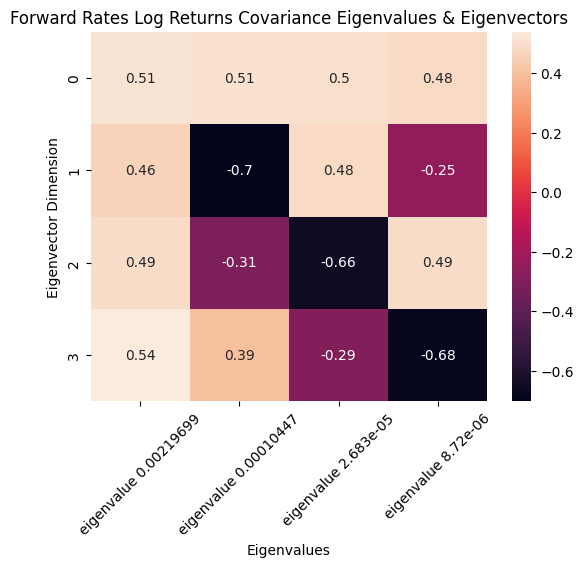

In [172]:
plt.figure()
sns.heatmap(forward_rates_log_returns_eigenvectors, annot=True)
plt.title("Forward Rates Log Returns Covariance Eigenvalues & Eigenvectors")
plt.xlabel("Eigenvalues")
plt.ylabel("Eigenvector Dimension")
plt.xticks(rotation=45)